In [1]:
from pyspark.sql.types import StructType, StructField, LongType, StringType, TimestampType
import pandas as pd
# Define schema for flattened research paper data with additional fields
schema = StructType(
    [
        StructField('hash_id', LongType(), True),  # Unique hash ID for the paper
        StructField('title', StringType(), True),  # Title of the paper
        StructField('authors', StringType(), True),  # Authors of the paper as a comma-separated string
        StructField('published', TimestampType(), True),  # Publication date of the paper
        StructField('summary', StringType(), True),  # Abstract or summary of the paper
        StructField('pdf_url', StringType(), True),  # URL to download the paper's PDF
        StructField('entry_id', StringType(), True),  # Unique entry ID for the paper (e.g., arXiv ID)
        StructField('recommended', LongType(), True),  # Flag indicating if the paper is recommended (1 if recommended, 0 otherwise)
        StructField('referenceCount', LongType(), True),  # Number of references in the paper
        StructField('citationCount', LongType(), True),  # Number of times the paper has been cited
        StructField('references', StringType(), True),  # JSON string of references
        StructField('citations', StringType(), True),  # JSON string of citations
        StructField('s2FieldsOfStudy', StringType(), True),  # JSON string of fields of study
        StructField('tldr', StringType(), True),  # JSON string for TLDR summary
        StructField('query_id', StringType(), True),  # Identifier for the query that generated the result
        StructField('Tag_1', StringType(), True),  # Additional tag 1
        StructField('Tag_2', StringType(), True),  # Additional tag 2
        StructField('Tag_3', StringType(), True),  # Additional tag 3
        StructField('Tag_4', StringType(), True),  # Additional tag 4
        StructField('Tag_5', StringType(), True),  # Additional tag 5
        StructField('field', StringType(), True)  # Field of the paper
    ]
)
!pip install transformers -U

StatementMeta(, , , Waiting, , Waiting)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 108.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 66.1 MB/s eta 0:00:00


  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface_hub 0.23.1
    Uninstalling huggingface_hub-0.23.1:
      Successfully uninstalled huggingface_hub-0.23.1
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.1
    Uninstalling tokenizers-0.15.1:
      Successfully uninstalled tokenizers-0.15.1
  Attempting uninstall: transformers


    Found existing installation: transformers 4.37.2


    Uninstalling transformers-4.37.2:


      Successfully uninstalled transformers-4.37.2


In [2]:
df = spark.sql("SELECT * FROM query.query_processing LIMIT 10000").dropDuplicates(["id"])

StatementMeta(, , , Waiting, , Waiting)

In [3]:
df.write.mode("overwrite").saveAsTable("query.query_processing")
df = spark.sql("SELECT * FROM query.query_processing LIMIT 10000")
df_pd = df.toPandas()

StatementMeta(, , , Waiting, , Waiting)

StatementMeta(, , , Waiting, , Waiting)

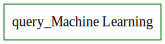

In [4]:
activities = []
for _,row in df_pd.iterrows():
    _id = row["id"]
    for q in eval(row["query_text"]):
        q = q.strip()
        activities.append({
            "name": f"query_{q}", # activity name, must be unique
            "path": "arxiv-search", # notebook path
            "timeoutPerCellInSeconds": 10000, # max timeout for each cell, default to 90 seconds
            "args": {"query_id": row["id"], "query": q , "paper_num":1
             , "date_from":row["date_from"] , 'date_to':row["date_to"]}, # notebook parameters
        })
        # run multiple notebooks with parameters
    DAG = {
        "activities": activities,
        "timeoutInSeconds": 43200, # max timeout for the entire DAG, default to 12 hours
        "concurrency": 50 # max number of notebooks to run concurrently, default to 50
    }
    mssparkutils.notebook.runMultiple(DAG, {"displayDAGViaGraphviz": True})
    tables = spark.catalog.listTables("silver")
    id_tables = ['silver.'+table.name for table in tables if table.name.startswith(f'_{_id}')]
    merged_df = spark.createDataFrame([],schema=schema)
    for table_name in id_tables:
        temp_df = spark.table(table_name)
        merged_df = merged_df.union(temp_df)
    merged_df = merged_df.distinct()
    merged_df.write.mode("overwrite").saveAsTable(f"silver._{_id}")
    activities = []
    # merged_df.write.mode("append").saveAsTable(f"silver.target")

StatementMeta(, 924123a7-886a-427a-ab89-9805258257fb, 42, Finished, Available, Finished)

In [42]:
import os
from email.policy import default

from azure.cosmos import CosmosClient, PartitionKey, exceptions
from typing import List, Dict, Any, Optional
import requests
import json
import hashlib
import hmac
import base64
from datetime import datetime , timezone


from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, ArrayType, MapType, TimestampType, LongType

# Define schema
schema = StructType([
    StructField("id", StringType(), True),
    StructField("user_id", StringType(), True),
    StructField("query_text", StringType(), True),
    StructField("date_from", StringType(), True),
    StructField("date_to", StringType(), True),
    StructField("priority", LongType(), True),
    StructField("email", StringType(), True),
    StructField("status", LongType(), True),
    StructField("metadata.created_at", TimestampType(), True),
    StructField("metadata.updated_at", TimestampType(), True),
    StructField("metadata.source", StringType(), True),
    StructField("partitionKey", StringType(), True),
    StructField("_rid", StringType(), True),
    StructField("_self", StringType(), True),
    StructField("_etag", StringType(), True),
    StructField("_attachments", StringType(), True),
    StructField("updated_at", StringType(), True),
    StructField("_ts", LongType(), True)
])



class CosmosDBClient:
    def __init__(self, url: str, key: str, database_name: str, container_name: str, partition_key: str):
        """
        Initialize the CosmosDBClient with Cosmos DB URL, key, database, container, and partition key.

        Parameters:
            url (str): Cosmos DB endpoint URL.
            key (str): Cosmos DB primary key for authorization.
            database_name (str): Name of the Cosmos DB database.
            container_name (str): Name of the Cosmos DB container.
            partition_key (str): Partition key path for the container.
        """
        self.url = url
        self.key = key
        self.database_name = database_name
        self.container_name = container_name
        self.partition_key = partition_key

        # Initialize Cosmos Client and connect to database and container
        try:
            self.client = CosmosClient(self.url, credential=self.key)
            self.database = self._create_database_if_not_exists()
            self.container = self._create_container_if_not_exists()
        except exceptions.CosmosHttpResponseError as e:
            print(f"Failed to connect to Cosmos DB: {e}")

    def _create_database_if_not_exists(self):
        """
        Create the database if it does not exist.

        Returns:
            DatabaseProxy: A reference to the Cosmos DB database.
        """
        return self.client.create_database_if_not_exists(id=self.database_name)

    def _create_container_if_not_exists(self):
        """
        Create the container if it does not exist with a specified partition key.

        Returns:
            ContainerProxy: A reference to the Cosmos DB container.
        """
        return self.database.create_container_if_not_exists(
            id=self.container_name,
            partition_key=PartitionKey(path=f"/{self.partition_key}"),
            offer_throughput=400  # Set the desired throughput
        )

    def create_document(self, data: Dict[str, Any]) -> Optional[Dict[str, Any]]:
        """
        Insert a document into the container. ID will be autogenerated if not provided.

        Parameters:
            data (Dict[str, Any]): Document data to insert.

        Returns:
            Optional[Dict[str, Any]]: The created document, or None if an error occurs.
        """
        try:
            data.setdefault(self.partition_key, "default_partition")  # Ensure partition key exists
            document = self.container.create_item(body=data)
            print("Document created successfully.")
            return document
        except exceptions.CosmosHttpResponseError as e:
            print(f"Error creating document: {e}")
            return None

    def upsert_document(self, data: Dict[str, Any]) -> Optional[Dict[str, Any]]:
        """
        Upsert (update or insert) a document in the container.

        Parameters:
            data (Dict[str, Any]): Document data to upsert.

        Returns:
            Optional[Dict[str, Any]]: The upserted document, or None if an error occurs.
        """
        try:
            data.setdefault(self.partition_key, "default_partition")
            document = self.container.upsert_item(body=data)
            print("Document upserted successfully.")
            return document
        except exceptions.CosmosHttpResponseError as e:
            print(f"Error upserting document: {e}")
            return None

    def read_document(self, document_id: str, partition_key: str) -> Optional[Dict[str, Any]]:
        """
        Read a document by ID.

        Parameters:
            document_id (str): The ID of the document to read.
            partition_key (str): The partition key of the document.

        Returns:
            Optional[Dict[str, Any]]: The retrieved document, or None if not found.
        """
        try:
            document = self.container.read_item(item=document_id, partition_key=partition_key)
            return document
        except exceptions.CosmosResourceNotFoundError:
            print("Document not found.")
            return None
        except exceptions.CosmosHttpResponseError as e:
            print(f"Error reading document: {e}")
            return None

    def query_documents(self, query: str) -> List[Dict[str, Any]]:
        """
        Query documents in the container.

        Parameters:
            query (str): SQL query string to execute.

        Returns:
            List[Dict[str, Any]]: A list of documents that match the query.
        """
        try:
            items = list(self.container.query_items(query=query, enable_cross_partition_query=True))
            return items
        except exceptions.CosmosHttpResponseError as e:
            print(f"Error querying documents: {e}")
            return []

    def delete_document(self, document_id: str, partition_key: str) -> bool:
        """
        Delete a document by ID.

        Parameters:
            document_id (str): The ID of the document to delete.
            partition_key (str): The partition key of the document.

        Returns:
            bool: True if the document was deleted, False otherwise.
        """
        try:
            self.container.delete_item(item=document_id, partition_key=partition_key)
            print("Document deleted successfully.")
            return True
        except exceptions.CosmosResourceNotFoundError:
            print("Document not found.")
            return False
        except exceptions.CosmosHttpResponseError as e:
            print(f"Error deleting document: {e}")
            return False

    def list_all_documents(self) -> List[Dict[str, Any]]:
        """
        List all documents in the container.

        Returns:
            List[Dict[str, Any]]: A list of all documents in the container.
        """
        try:
            items = list(self.container.read_all_items())
            return items
        except exceptions.CosmosHttpResponseError as e:
            print(f"Error listing all documents: {e}")
            return []


import pandas as pd

COSMOS_URL = ''
COSMOS_KEY = ""
DATABASE_NAME = ''
CONTAINER_NAME = ''
PARTITION_KEY = ''  # Ensure this matches the partition key path in your Cosmos DB

USER_ID = ""

cosmos_client_query = CosmosDBClient(
    url=COSMOS_URL,
    key=COSMOS_KEY,
    database_name=DATABASE_NAME,
    container_name=CONTAINER_NAME,
    partition_key=PARTITION_KEY
)
def appendTable(source,name):
    spark_df = spark.createDataFrame(source,schema)
    spark_df.write.mode("append").format("delta").saveAsTable(name)

try:
    df = spark.sql("SELECT * FROM query.query_processing  WHERE status=1 ORDER BY priority LIMIT 1000")
except:
    appendTable([],"query_completed")
    df = spark.sql("SELECT * FROM query.query_processing  WHERE status=1 ORDER BY priority LIMIT 1000")


df_pd = df.toPandas()



for _id, user_id in zip(df_pd["id"], df_pd["user_id"]):
    # Query to get the specific document by its ID and user_id (partition key)
    query = f"SELECT * FROM c WHERE c.id = '{_id}' AND c.user_id = '{user_id}'"
    documents = cosmos_client_query.query_documents(query=query)
    
    if documents:
        document = documents[0]  # Assuming each ID corresponds to a single document
        
        # Update the status and add a timestamp
        document['status'] = 2
        document['updated_at'] = datetime.now(timezone.utc).isoformat()  # Optional timestamp
        
        # Upsert the updated document back into Cosmos DB
        cosmos_client_query.upsert_document(document)


df_pd["status"] =2

try:
    appendTable(df_pd,"query.query_completed")
except:
    pass


spark.sql("DROP TABLE IF EXISTS query.query_processing")
empty_pending = spark.createDataFrame([], schema)
appendTable([],"query.query_processing")


StatementMeta(, 924123a7-886a-427a-ab89-9805258257fb, 45, Finished, Available, Finished)

Document upserted successfully.


In [3]:
# t = spark.catalog.listTables("silver")
# for i in t:
#     if(i.name.startswith("_")):
#         spark.sql(f"DROP TABLE silver.{i.name}")

StatementMeta(, , , Waiting, , Waiting)

In [ ]:
lResult = {
    "query_filename_list": [
        {
            "email": email,
            "id":_id,
            "query_text": query_text,
            "date_from": date_from,
            "date_to": date_to,
            "user_id": user_id,
        }
        for email, _id , query_text, date_from, date_to,user_id,priority in zip(
            df_pd["email"], df_pd["id"] , df_pd["query_text"], df_pd["date_from"], df_pd["date_to"] , df_pd["user_id"]
            ,df_pd["priority"]
        )
    ]
}
mssparkutils.notebook.exit(str(lResult))

StatementMeta(, , , Waiting, , Waiting)

ExitValue: {'query_filename_list': [{'email': '101540385@georgebrown.ca', 'id': '1c8001a6e68b47e2a04627531d939bb3', 'query_text': '["Machine Learning"]', 'date_from': '2024-03-10', 'date_to': '2024-05-25', 'user_id': 'Alan Choi'}, {'email': '101540385@georgebrown.ca', 'id': 'ecf967251e6747248e6e79aa564301c2', 'query_text': '["Robotics"]', 'date_from': '2024-06-19', 'date_to': '2024-08-23', 'user_id': 'Alan Choi'}, {'email': '101540385@georgebrown.ca', 'id': 'fc827af370664e82919b0b3db4f856ca', 'query_text': '["Large Language Model"]', 'date_from': '2024-05-10', 'date_to': '2024-10-17', 'user_id': 'Alan Choi'}]}